In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [5]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
model = FastText.load('Model/XGB.bin')

In [8]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [9]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [10]:
lc = preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc = lc.transform(y_train)
y_test_enc = lc.transform(y_test)

In [12]:
train = xgb.DMatrix(X_train_vector,label=y_train_enc)
test = xgb.DMatrix(X_test_vector,label=y_test_enc)

In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.37761	test-merror:0.55056
[1]	train-merror:0.29494	test-merror:0.52327
[2]	train-merror:0.24679	test-merror:0.50241
[3]	train-merror:0.22191	test-merror:0.47512
[4]	train-merror:0.19502	test-merror:0.47030
[5]	train-merror:0.18660	test-merror:0.46709
[6]	train-merror:0.16132	test-merror:0.45104
[7]	train-merror:0.14045	test-merror:0.44944
[8]	train-merror:0.12801	test-merror:0.44462
[9]	train-merror:0.12239	test-merror:0.45746
[10]	train-merror:0.11236	test-merror:0.45746
[11]	train-merror:0.10594	test-merror:0.45265
[12]	train-merror:0.09952	test-merror:0.44623
[13]	train-merror:0.09189	test-merror:0.46067
[14]	train-merror:0.08588	test-merror:0.46228
[15]	train-merror:0.08507	test-merror:0.45425
[16]	train-merror:0.08347	test-merror:0.45265
[17]	train-merror:0.08267	test-merror:0.44944
[18]	train-merror:0.08226	test-merror:0.42697
[19]	train-merror:0.07865	test-merror:0.43820
[20]	train-merror:0.07263	test-merror:0.43660
[21]	train-merror:0.07384	test-merror:0.4317

[177]	train-merror:0.01445	test-merror:0.42215
[178]	train-merror:0.01565	test-merror:0.42055
[179]	train-merror:0.01525	test-merror:0.42055
[180]	train-merror:0.01525	test-merror:0.42055
[181]	train-merror:0.01525	test-merror:0.41573
[182]	train-merror:0.01525	test-merror:0.41894
[183]	train-merror:0.01525	test-merror:0.42055
[184]	train-merror:0.01525	test-merror:0.42215
[185]	train-merror:0.01445	test-merror:0.41894
[186]	train-merror:0.01445	test-merror:0.42536
[187]	train-merror:0.01485	test-merror:0.42215
[188]	train-merror:0.01445	test-merror:0.42055
[189]	train-merror:0.01485	test-merror:0.42055
[190]	train-merror:0.01485	test-merror:0.41894
[191]	train-merror:0.01485	test-merror:0.41734
[192]	train-merror:0.01445	test-merror:0.41734
[193]	train-merror:0.01364	test-merror:0.41894
[194]	train-merror:0.01364	test-merror:0.41894
[195]	train-merror:0.01364	test-merror:0.41734
[196]	train-merror:0.01364	test-merror:0.41894
[197]	train-merror:0.01364	test-merror:0.42055
[198]	train-m

[352]	train-merror:0.00281	test-merror:0.41573
[353]	train-merror:0.00281	test-merror:0.41734
[354]	train-merror:0.00281	test-merror:0.41573
[355]	train-merror:0.00281	test-merror:0.41413
[356]	train-merror:0.00281	test-merror:0.41413
[357]	train-merror:0.00281	test-merror:0.41413
[358]	train-merror:0.00281	test-merror:0.41573
[359]	train-merror:0.00281	test-merror:0.41573
[360]	train-merror:0.00281	test-merror:0.41573
[361]	train-merror:0.00281	test-merror:0.41573
[362]	train-merror:0.00281	test-merror:0.41413
[363]	train-merror:0.00281	test-merror:0.41413
[364]	train-merror:0.00281	test-merror:0.41573
[365]	train-merror:0.00281	test-merror:0.41413
[366]	train-merror:0.00281	test-merror:0.41413
[367]	train-merror:0.00241	test-merror:0.41413
[368]	train-merror:0.00241	test-merror:0.41413
[369]	train-merror:0.00281	test-merror:0.41252
[370]	train-merror:0.00281	test-merror:0.41413
[371]	train-merror:0.00281	test-merror:0.41252
[372]	train-merror:0.00281	test-merror:0.41573
[373]	train-m

[527]	train-merror:0.00080	test-merror:0.40610
[528]	train-merror:0.00080	test-merror:0.40610
[529]	train-merror:0.00080	test-merror:0.40449
[530]	train-merror:0.00080	test-merror:0.40449
[531]	train-merror:0.00080	test-merror:0.40449
[532]	train-merror:0.00080	test-merror:0.40128
[533]	train-merror:0.00080	test-merror:0.40289
[534]	train-merror:0.00040	test-merror:0.40128
[535]	train-merror:0.00040	test-merror:0.40289
[536]	train-merror:0.00080	test-merror:0.40289
[537]	train-merror:0.00040	test-merror:0.40610
[538]	train-merror:0.00040	test-merror:0.40449
[539]	train-merror:0.00040	test-merror:0.40449
[540]	train-merror:0.00040	test-merror:0.40289
[541]	train-merror:0.00040	test-merror:0.40289
[542]	train-merror:0.00040	test-merror:0.40128
[543]	train-merror:0.00040	test-merror:0.40289
[544]	train-merror:0.00040	test-merror:0.40289
[545]	train-merror:0.00040	test-merror:0.40128
[546]	train-merror:0.00040	test-merror:0.40128
[547]	train-merror:0.00040	test-merror:0.40128
[548]	train-m

[702]	train-merror:0.00040	test-merror:0.39486
[703]	train-merror:0.00040	test-merror:0.39486
[704]	train-merror:0.00040	test-merror:0.39486
[705]	train-merror:0.00040	test-merror:0.39647
[706]	train-merror:0.00040	test-merror:0.39486
[707]	train-merror:0.00040	test-merror:0.39647
[708]	train-merror:0.00040	test-merror:0.39647
[709]	train-merror:0.00040	test-merror:0.39486
[710]	train-merror:0.00040	test-merror:0.39486
[711]	train-merror:0.00040	test-merror:0.39647
[712]	train-merror:0.00040	test-merror:0.39647
[713]	train-merror:0.00040	test-merror:0.39647
[714]	train-merror:0.00040	test-merror:0.39647
[715]	train-merror:0.00040	test-merror:0.39647
[716]	train-merror:0.00040	test-merror:0.39647
[717]	train-merror:0.00040	test-merror:0.39807
[718]	train-merror:0.00040	test-merror:0.39647
[719]	train-merror:0.00040	test-merror:0.39647
[720]	train-merror:0.00040	test-merror:0.39968
[721]	train-merror:0.00040	test-merror:0.39968
[722]	train-merror:0.00040	test-merror:0.39807
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.40128
[878]	train-merror:0.00000	test-merror:0.39968
[879]	train-merror:0.00000	test-merror:0.40128
[880]	train-merror:0.00000	test-merror:0.39968
[881]	train-merror:0.00000	test-merror:0.39968
[882]	train-merror:0.00000	test-merror:0.39968
[883]	train-merror:0.00000	test-merror:0.39807
[884]	train-merror:0.00000	test-merror:0.40128
[885]	train-merror:0.00000	test-merror:0.40128
[886]	train-merror:0.00000	test-merror:0.39968
[887]	train-merror:0.00000	test-merror:0.39968
[888]	train-merror:0.00000	test-merror:0.40128
[889]	train-merror:0.00000	test-merror:0.40128
[890]	train-merror:0.00000	test-merror:0.40128
[891]	train-merror:0.00000	test-merror:0.40128
[892]	train-merror:0.00000	test-merror:0.39968
[893]	train-merror:0.00000	test-merror:0.39968
[894]	train-merror:0.00000	test-merror:0.39968
[895]	train-merror:0.00000	test-merror:0.39807
[896]	train-merror:0.00000	test-merror:0.39807
[897]	train-merror:0.00000	test-merror:0.39807
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.5987158908507223 

Train Score
 1.0 

CONFUSSION MATRIX
 [[160  38  22]
 [ 53 103  44]
 [ 41  52 110]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.63      0.73      0.68       220
      netral       0.53      0.52      0.52       200
     positif       0.62      0.54      0.58       203

    accuracy                           0.60       623
   macro avg       0.60      0.59      0.59       623
weighted avg       0.60      0.60      0.60       623
 



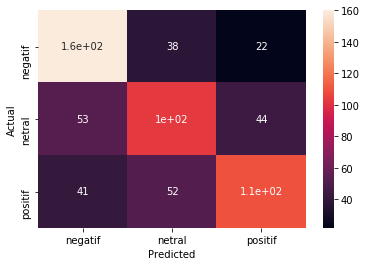

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)